In [154]:
import sklearn_crfsuite
from type import CrfFeatures, Abbreviation, CrfLabel
import json
from sklearn.model_selection import train_test_split
import sklearn_crfsuite.metrics
from util.levenshtein_distance import edit_dist
import numpy as np
import matplotlib.pyplot as plt

In [155]:
# 前処理した略語データを読み込む
data = list(map(Abbreviation.model_validate, json.load(open("./data/abbreviation.json", "r"))))
data_train: list[Abbreviation] = []
data_test: list[Abbreviation] = []
data_train, data_test = train_test_split(data, test_size=0.2)

In [156]:
X_train = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_train)]
y_train = list(map(CrfLabel.from_abbreviation, data_train))
X_test = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_test)]
y_test = list(map(CrfLabel.from_abbreviation, data_test))

In [157]:
model = sklearn_crfsuite.CRF(algorithm="lbfgs", c1=0.1, c2=0.1, max_iterations=100000, all_possible_transitions=True)
model.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100000)

In [158]:
y_pred = model.predict(X_test)

In [159]:
sklearn_crfsuite.metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.6945035940847502

In [160]:
test_n = len(y_test)
correct_n = 0
score_list = np.array([0.0] * test_n) # スコアは 編集距離 / 単語のモーラ数 で定義する

for i in range(len(y_test)):
    word_mora_list = [mora for elem in data_test[i].word_element_list for mora in elem.mora_list]
    word = " ".join([f"{mora.consonant}{mora.vowel}" for mora in word_mora_list])
    abbr_pred_list: list[str] = []
    assert len(y_pred[i]) == len(y_test[i]) == len(word_mora_list)
    for j in range(len(y_test[i])):
        if y_pred[i][j] == CrfLabel.OK:
            abbr_pred_list.append(word_mora_list[j].consonant + word_mora_list[j].vowel)
    score_list[i] = edit_dist(y_pred[i], y_test[i]) / len(y_test[i])
    correct_n += y_pred[i] == y_test[i]
    print('{:.3f}'.format(score_list[i]), f"{word} -> {' '.join(abbr_pred_list)}")

0.250 e N ji N su to Q pu -> e N
0.000 su te e ji ma ne ja a -> su te e ji ma ne
0.000 e su ke e pu -> e su
0.000 ko N pu ri i to -> ko N pu
0.000 gu ro te su ku -> gu ro
0.167 ka ra a te re bi -> ka ra
0.250 se N ta a fi ru da a -> se N ta a fi ru
0.167 da Q gu ma Q chi -> da Q
0.167 ka re e ra i su -> ka re
0.500 ne o N sa i N -> 
1.000 sa u N do e fe ku to -> sa u N do
0.444 yu u thi ri thi i ru u mu -> yu u
0.125 ko re su po N de N su -> ko re
0.375 su pu ri N to re e su -> su pu
0.000 te ro ri zu mu -> te ro
0.200 ru N pe N pu ro re ta ri a -> ru N pe N pu ro
0.500 bu gi u gi -> bu gi u gi
0.222 ko su to pa fo o ma N su -> ko su to pa fo
0.000 i N pu ri me N to -> i N pu ri
0.333 o o ke su to ra -> o o
0.000 kya ba shi thi i -> kya ba
0.167 ka ra a fi ru mu -> ka ra
0.143 te re ho N ka a do -> te re
0.000 su pe sha ru -> su pe
0.200 ra i bu sho o -> ra i
0.714 su pe e su sha to ru -> su pe
0.714 a N gu ro a Q pu -> a N gu ro
0.000 ki ro gu ra mu -> ki ro
0.000 ma zo hi su to -> ma

In [161]:
print(f"Accuracy: {correct_n / test_n}")

Accuracy: 0.20866141732283464


(array([54., 36., 74., 34.,  8., 10., 12., 14.,  4.,  8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

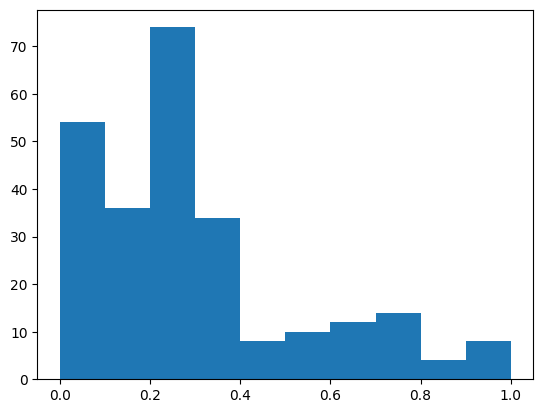

In [162]:
plt.hist(score_list, bins=10)